# Process 'Student Internship / Top Skills to Success' Question Using a LLM

A generic version of the pipeline to be re-used for different types of questions.

Andrew Weng, 1/1/2025

We are going to use a mixed LLM-Python approach to solve the problem of "user text categorization."

This problem can be decomposed into five steps:

1. Pre-process (LLM1)
 - Each user provides up to three keywords as a string. These keywords need to be normalized and stored in a large list of individual keywords for the next stage.
2. Define categories (LLM2)
 - With the list of keywords, find the best set of categories to describe the keywords
3. Assign categories (LLM3)
 - For each keyword, assign it to a category. Be careful about how to handle exceptions (e.g., a keyword that doesn't seem to belog into any particular category.)
4. Count occurences (Python)
 - Within each category, sum up the total number of keywords. 
5. Visualize the results (Python)

In [1]:
import os
import time

current_folder = os.path.basename(os.getcwd())
if current_folder == 'notebooks':
    root_path = os.path.dirname(os.path.abspath(''))
    os.chdir(root_path)

from src.analyst import Analyst
from src.plotter import Plotter
from src.llm import LLM

from collections import defaultdict

import pickle
from pprint import pprint

from IPython import get_ipython
# Automatically reload all modules every time a line of code is executed
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')

# Initialize our helper classes

In [2]:
analyst = Analyst()
analyst.load_data()
analyst.build_respondents_list()

plotter = Plotter()
llm = LLM()

# Fetch the relevant dataset to analyze

In [15]:
question = dict()
question['tag']= 'student_internship_skills_top'
question['categories'] = [
    'Electrochemistry / Electrochemical Characterization'
    'Battery / Cell Testing, Fabrication, Design, Assembly',
    'Materials Development',
    'Materials Characterization / Material Science',
    'Programming / Coding / Software / Simulation',
    'Data Analysis / Processing / Analytics',
    'Communication / Writing / Presentation / Language',
    'Research Skills / Experimental Design / Lab Work'
    'Leadership / Management / Project Development',
    'Personal Attributes / Soft Skills',
    'Problem Solving / Troubleshooting',
    'Creativity / Innovation / Proactivity',
    'Machine Learning / AI',
    'Thermal Management / HVAC',
    'Quality Control / Testing / Inspection',
    'Teaching',
    'Battery Management Systems',
    'Controls / Control Systems',
    'Recycling',
    'Chemistry / Technical Knowledge',
    'Interdisciplinary Skills'
]

question['question'] = 'During your previous internship, what are the top three skills that contributed to your success?'
question['data'] = analyst.summarize_student_internship()['internship_top_skills_list']

In [4]:
question['data']

['Grit; communication; coding',
 'Chemistry knowledge, battery physics fundamentals, data analysis',
 'Skill 1: Knowledge, Skill 2: Communication, Skill 3: Discipline',
 'communication, research skill, troubleshooting',
 'Interpersonal communication, problem solving, leadership',
 'EIS; Data processing; Asking the right questions',
 '"AI; interdiciplinary"',
 'Reinforcement Learning, Thermal Controls, HVAC',
 'Characterisation; Battery Testing; Cell Fabrication',
 'Intuition',
 'Efficiency; Foresight; Python',
 'Deep understanding of electrochemistry; organization; writing skills',
 'Presentation and data analysis',
 'CAD, FEA, PLM',
 '"Finite Element Method Simulation", "Product Design", "Electrochemistry"',
 'Electrochemical characterization techniques, material characterization,; communication; collaboration',
 'XAS sampling, XAS data analysis, Manuscript writing',
 'product design, R&D',
 'Quantitative analysis, understanding of li-ion degradation',
 'Electrochemical knowledge, wor

# Pre-process the user response

Interpret the delimiters

In [5]:
keyword_list = []

for i, string_of_list in enumerate(question['data']):
    print(f"Processing response {i+1} of {len(question['data'])}")
    list_of_strings = llm.delimit_string_of_list(string_of_list)
    print(f'--> {list_of_strings}\n')
    keyword_list.extend(list_of_strings)

# Assemble and cache the list
print(keyword_list)
timestamp = time.strftime('%Y%m%d_%H%M%S')
with open(f'data/strlist_{question['tag']}_{timestamp}.pkl', 'wb') as f:
    pickle.dump(keyword_list, f)

Processing response 1 of 49
--> ['Grit', 'communication', 'coding']

Processing response 2 of 49
--> ['Chemistry knowledge', 'battery physics fundamentals', 'data analysis']

Processing response 3 of 49
--> ['Knowledge', 'Communication', 'Discipline']

Processing response 4 of 49
--> ['communication', 'research skill', 'troubleshooting']

Processing response 5 of 49
--> ['Interpersonal communication', 'problem solving', 'leadership']

Processing response 6 of 49
--> ['EIS', 'Data processing', 'Asking the right questions']

Processing response 7 of 49
--> ['AI', 'interdiciplinary']

Processing response 8 of 49
--> ['Reinforcement Learning', 'Thermal Controls', 'HVAC']

Processing response 9 of 49
--> ['Characterisation', 'Battery Testing', 'Cell Fabrication']

Processing response 10 of 49
--> ['Intuition']

Processing response 11 of 49
--> ['Efficiency', 'Foresight', 'Python']

Processing response 12 of 49
--> ['Deep understanding of electrochemistry', 'organization', 'writing skills']


# Define categories

In [6]:
if question['categories'] == []:

    categories = llm.define_categories(question['question'],
                                       keyword_list,
                                       num_categories=50)

    category_list = []
    for category in categories['categories']:
        category_list.append(category['name'])

else:
    category_list = question['categories']

pprint(category_list)

['Electrochemistry / Electrochemical Knowledge / Electrochemical '
 'Characterization Techniques',
 'Battery Testing / Cell Testing / Cell Fabrication / Cell Design / Cell '
 'Assembly',
 'Cathode Materials Development / Electrolyte Development',
 'Materials Characterization / Material Science',
 'Programming / Coding / Software Skills / Simulation',
 'Data Analysis / Data Processing / Data Analytics / Quantitative Analysis',
 'Communication Skills / Writing Skills / Presentation / Language Skills',
 'Research Skills / Experimental Design / Advanced Research / Laboratory Work '
 '/ R&D',
 'Leadership / Management / Project Development / Design',
 'Personal Attributes / Soft Skills',
 'Problem Solving / Troubleshooting',
 'Creativity / Innovation / Proactivity',
 'Machine Learning / AI',
 'Thermal Management / HVAC',
 'Quality Control / Testing / Industrial Inspection',
 'Teaching',
 'Battery Management Systems / BMS',
 'Controls / Control Systems',
 'Recycling',
 'Chemistry / Technical

# Assign categories

Process one keyword at a time!

In [7]:
content_list = []
other_list = []
fail_list = []

for i, keyword in enumerate(keyword_list):

    print(f"Processing response: '{keyword}' ({i+1} of {len(keyword_list)})...")

    try:
        output = llm.classify_user_response(category_list, keyword,
                                            model='gpt-4o-mini')
    except: # JSON output fails
        fail_list.append(keyword)
        continue

    if output['result']['category'] in category_list:
        content_list.append(output)
    else:
        other_list.append(output)

Processing response: 'Grit' (1 of 136)...
Processing response: 'communication' (2 of 136)...
Processing response: 'coding' (3 of 136)...
Processing response: 'Chemistry knowledge' (4 of 136)...
Processing response: 'battery physics fundamentals' (5 of 136)...
Processing response: 'data analysis' (6 of 136)...
Processing response: 'Knowledge' (7 of 136)...
Processing response: 'Communication' (8 of 136)...
Processing response: 'Discipline' (9 of 136)...
Processing response: 'communication' (10 of 136)...
Processing response: 'research skill' (11 of 136)...
Processing response: 'troubleshooting' (12 of 136)...
Processing response: 'Interpersonal communication' (13 of 136)...
Processing response: 'problem solving' (14 of 136)...
Processing response: 'leadership' (15 of 136)...
Processing response: 'EIS' (16 of 136)...
Processing response: 'Data processing' (17 of 136)...
Processing response: 'Asking the right questions' (18 of 136)...
Processing response: 'AI' (19 of 136)...
Processing re

In [8]:
print(len(other_list))

8


In [9]:
other_list

[{'result': {'response_text': 'Knowledge', 'category': 'Other'}},
 {'result': {'response_text': 'Efficiency', 'category': 'Other'}},
 {'result': {'response_text': 'FEA', 'category': 'Other'}},
 {'result': {'response_text': 'PLM', 'category': 'Other'}},
 {'result': {'response_text': 'product design',
   'category': 'Battery Design / Cell Design / Cell Fabrication / Cell Testing'}},
 {'result': {'response_text': 'Science Skills', 'category': 'Other'}},
 {'result': {'response_text': 'Fundamental Understanding',
   'category': 'Other'}},
 {'result': {'response_text': 'Blade Coating', 'category': 'Other'}}]

In [10]:
print(len(fail_list))

0


## Assembly dictionary for plotting and a 'collection' dictionary

The 'collection' is a reference for which keywords got sorted into which categories.

In [11]:

collection = defaultdict(list)
counter    = defaultdict(int)

for content in content_list:

    category = content['result']['category']
    response = content['result']['response_text']
    counter[category] += 1
    collection[category].append(response)

counter['_tot_'] = len(question['data'])
counter

defaultdict(int,
            {'Personal Attributes / Soft Skills': 17,
             'Communication Skills / Writing Skills / Presentation / Language Skills': 17,
             'Programming / Coding / Software Skills / Simulation': 8,
             'Chemistry / Technical Knowledge': 5,
             'Data Analysis / Data Processing / Data Analytics / Quantitative Analysis': 12,
             'Research Skills / Experimental Design / Advanced Research / Laboratory Work / R&D': 7,
             'Problem Solving / Troubleshooting': 5,
             'Leadership / Management / Project Development / Design': 3,
             'Electrochemistry / Electrochemical Knowledge / Electrochemical Characterization Techniques': 9,
             'Machine Learning / AI': 3,
             'Interdisciplinary Skills': 1,
             'Controls / Control Systems': 2,
             'Thermal Management / HVAC': 2,
             'Materials Characterization / Material Science': 8,
             'Battery Testing / Cell Testing

In [12]:
collection

defaultdict(list,
            {'Personal Attributes / Soft Skills': ['Grit',
              'Discipline',
              'Intuition',
              'organization',
              'work ethic',
              'curiosity',
              'Hard work',
              'passience',
              'Scientific integrity',
              'proactivity',
              'eagerness to learn',
              'Adaptability',
              'time management',
              'people skills',
              'hard working',
              'perseverance',
              'initiative'],
             'Communication Skills / Writing Skills / Presentation / Language Skills': ['communication',
              'Communication',
              'communication',
              'Interpersonal communication',
              'writing skills',
              'Presentation',
              'communication',
              'Manuscript writing',
              'Language Skills',
              'communication',
              'collaboration',
       

# Visualize the results

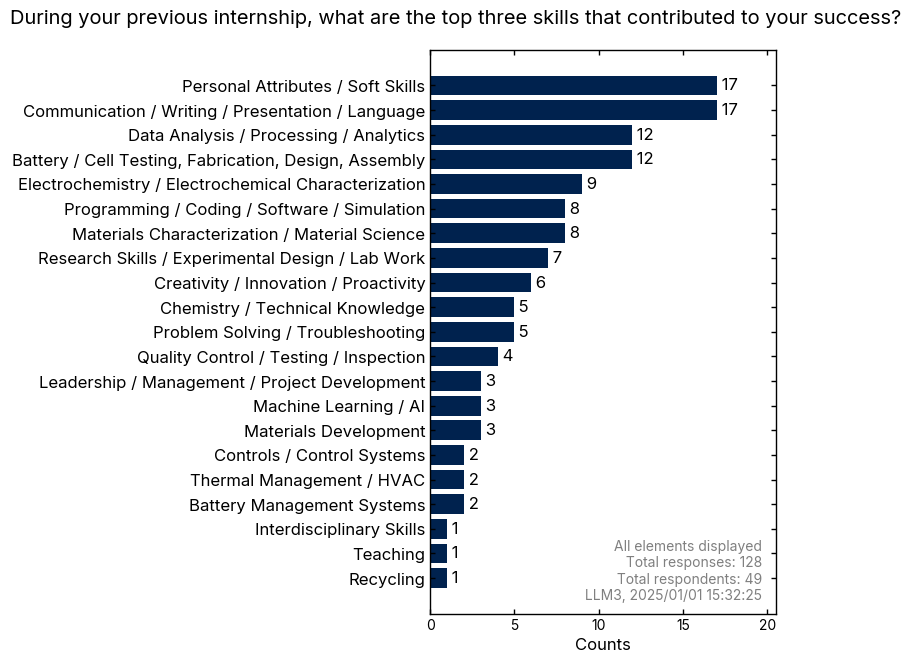

In [19]:
plotter.make_bar_plot_from_dict(counter,
                                title=question['question'],
                                sorted=True,
                                annotation=f'LLM3, {time.strftime("%Y/%m/%d %H:%M:%S")}',
                                num_elements=100,
                                saveas=f'{question['tag']}_{time.strftime("%Y%m%d_%H%M%S")}.png'
)